<a href="https://colab.research.google.com/github/katjakon/GurkLM/blob/dev2/eval_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evaluating


Cloning the repository:

In [ ]:
!git clone https://github.com/katjakon/GurkLM.git

Cloning into 'GurkLM'...
remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 321 (delta 163), reused 278 (delta 131), pack-reused 0 (from 0)
Receiving objects: 100% (321/321), 1.18 MiB | 1.04 MiB/s, done.
Resolving deltas: 100% (163/163), done.


Next, we install necessary packages

In [2]:
!pip install datasets conllu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.7 MB/s eta 0:00:00


This is necessary to be able to import custom functions and classes.

In [3]:
import sys
sys.path.insert(0,'/content/GurkLM')

Mount the Google Drive, so we are able to import model checkpoints.

In [4]:
import os
import json
from statistics import mean
import torch
from transformers import BertTokenizerFast, BertModel, AutoModelForMaskedLM
from tqdm import tqdm

from evaluate import save_metrics
from gurk.classifier import UpperBoundClassifier, RandomBaseline, train_model
from gurk.ud_data import get_ud_data, get_code_mapping, get_pos_mapping
from gurk.masked_predict import accuracy_at_n, predict_masked_bert

In [5]:
# Some variable that are the same for all validation tasks
ud_ds = "qtd_sagt" # Identifier of Universal Dependencies data set
# We don't bother optimizing hyperparameters:
batch_size = 16
n_epochs = 5
lr = 0.001

Set device:

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Upper Bound Classifier
Here, we evaluate the performance of a pre-trained multilingual BERT model on the validation task

In [7]:
model_type = "google-bert/bert-base-multilingual-cased" # model to use as a base for upper bound clf.
result_dir = "result_mbert" # where to store results.


In [8]:
res_path = os.path.join(result_dir)
if not os.path.exists(res_path):
  os.mkdir(res_path)

In [9]:
tokenizer = BertTokenizerFast.from_pretrained(model_type)
model = BertModel.from_pretrained(model_type)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

### Part-of-Speech Tagging
We investigate the performance on labeling words with part-of-speech tags.

In [10]:
train_pos_dl, val_pos_dl, test_pos_dl = get_ud_data(
  ud_ds,
  batch_size=batch_size,
  tokenizer=tokenizer,
  label_type="upos")


README.md:   0%|          | 0.00/191k [00:00<?, ?B/s]

universal_dependencies.py:   0%|          | 0.00/87.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/285 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/801 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/805 [00:00<?, ? examples/s]

Map:   0%|          | 0/285 [00:00<?, ? examples/s]

Map:   0%|          | 0/801 [00:00<?, ? examples/s]

Map:   0%|          | 0/805 [00:00<?, ? examples/s]

In [11]:
dim = model.config.hidden_size
pos_classes = get_pos_mapping(train_pos_dl.dataset) # Mapping from class label to index
num_classes = len(pos_classes)

clf_nn = UpperBoundClassifier(num_classes, model, dim=dim)

# Train model.
logs = train_model(
clf_nn,
train_pos_dl,
val_pos_dl,
lr=lr,
n_epochs=n_epochs,
pad_token_id=tokenizer.pad_token_id
)



Validating...: 100%|██████████| 51/51 [00:09<00:00,  5.57it/s]


Train Loss: 32.66919183731079	 Train Accuracy 0.4609973101593213
Val Loss: 57.280243277549744	 Val Accuracy 0.6922901459854015


Validating...: 100%|██████████| 51/51 [00:08<00:00,  5.80it/s]


Train Loss: 15.059652388095856	 Train Accuracy 0.7490171735981792
Val Loss: 38.878419280052185	 Val Accuracy 0.7684002433090025


Validating...: 100%|██████████| 51/51 [00:08<00:00,  5.80it/s]


Train Loss: 10.16596233844757	 Train Accuracy 0.8292985723153321
Val Loss: 34.88996350765228	 Val Accuracy 0.7838351581508516


Validating...: 100%|██████████| 51/51 [00:08<00:00,  5.70it/s]


Train Loss: 7.96462544798851	 Train Accuracy 0.8665425201738051
Val Loss: 32.30534067749977	 Val Accuracy 0.8083941605839416


Validating...: 100%|██████████| 51/51 [00:08<00:00,  5.80it/s]

Train Loss: 6.62653261423111	 Train Accuracy 0.8913718187461204
Val Loss: 33.75068402290344	 Val Accuracy 0.8021593673965937


Predicting..: 100%|██████████| 51/51 [00:02<00:00, 19.88it/s]


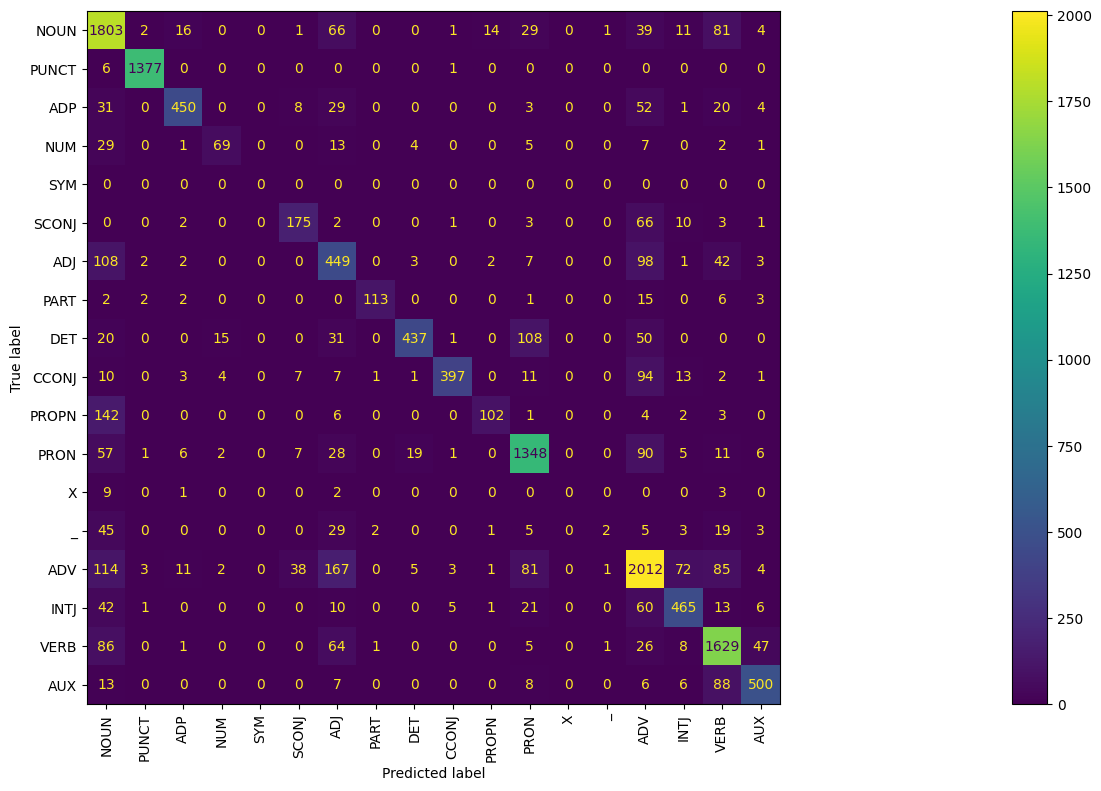

In [12]:
pred = save_metrics(
    pos_classes,
    test_pos_dl,
    clf_nn,
    task="upos",
    output=res_path,
    pad_token_id=tokenizer.pad_token_id
)

### Language Code Prediction
We also evaluate on the ability of predicting the language in our data set. There are 4 different classes: German, Turkish, Mixed (code-switching) and Other (such as punctuation)

Again, we load the data set.

In [13]:
train_code_dl, val_code_dl, test_code_dl = get_ud_data(
  ud_ds,
  batch_size=batch_size,
  tokenizer=tokenizer,
  label_type="lang-code")

Map:   0%|          | 0/285 [00:00<?, ? examples/s]

Map:   0%|          | 0/801 [00:00<?, ? examples/s]

Map:   0%|          | 0/805 [00:00<?, ? examples/s]

In [14]:
dim = model.config.hidden_size
code_classes = get_code_mapping() # Mapping from class label to index
num_classes = len(code_classes)


clf_nn = UpperBoundClassifier(num_classes, model, dim=dim)

# Train model.
logs = train_model(
clf_nn,
train_code_dl,
val_code_dl,
lr=lr,
n_epochs=n_epochs,
pad_token_id=tokenizer.pad_token_id
)

Validating...: 100%|██████████| 51/51 [00:08<00:00,  5.79it/s]


Train Loss: 8.9056646078825	 Train Accuracy 0.8222636043865094
Val Loss: 13.258727334439754	 Val Accuracy 0.9280717761557178


Validating...: 100%|██████████| 51/51 [00:08<00:00,  5.82it/s]


Train Loss: 3.185466952621937	 Train Accuracy 0.9451686323194703
Val Loss: 11.191351383924484	 Val Accuracy 0.9342305352798054


Validating...: 100%|██████████| 51/51 [00:08<00:00,  5.78it/s]


Train Loss: 2.408047202974558	 Train Accuracy 0.957376370784192
Val Loss: 11.23138353228569	 Val Accuracy 0.9364355231143552


Validating...: 100%|██████████| 51/51 [00:08<00:00,  5.81it/s]


Train Loss: 1.863979585468769	 Train Accuracy 0.9658597144630664
Val Loss: 10.584123369306326	 Val Accuracy 0.9384124087591241


Validating...: 100%|██████████| 51/51 [00:08<00:00,  5.80it/s]

Train Loss: 1.4640234895050526	 Train Accuracy 0.9741361473205049
Val Loss: 10.708925403654575	 Val Accuracy 0.9389446472019465


Predicting..: 100%|██████████| 51/51 [00:02<00:00, 19.99it/s]


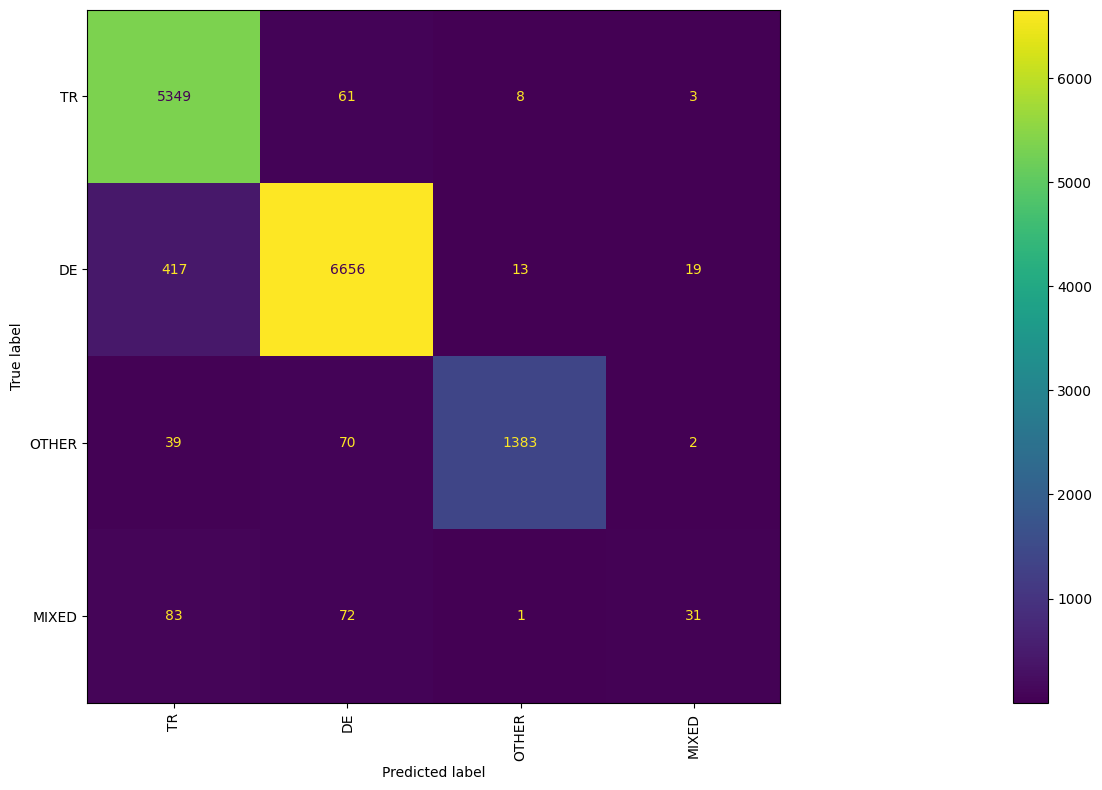

In [15]:
pred = save_metrics(
    code_classes,
    test_code_dl,
    clf_nn,
    task="lang-code",
    output=res_path,
    pad_token_id=tokenizer.pad_token_id
)

### Masked Token Prediction
We also evaluate how well a model can predict masked tokens. We take a sequence and mask each token once.

In [ ]:
lm_model = AutoModelForMaskedLM.from_pretrained(model_type).to(device)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at google-bert/bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.p

In [ ]:
train_dl, val_dl, test_dl = get_ud_data(ud_ds, batch_size=batch_size, tokenizer=tokenizer, label_type="mlm")

In [ ]:
accs3 = []
accs5 = []
accs1 = []
lm_model.eval()
for line in tqdm(test_dl.dataset, desc="Predicting masked tokens.."):
  text = line["text"]
  max_len = tokenizer.model_max_length
  mask_token_id = tokenizer.mask_token_id
  input_ids =  tokenizer(
        text,
        add_special_tokens=False,
        return_tensors="pt",
        max_length=max_len,
        truncation=True)["input_ids"]
  pred = predict_masked_bert(input_ids, lm_model, mask_token_id)
  acc1 = accuracy_at_n(y_true=input_ids, y_pred=pred, n=1)
  acc3 = accuracy_at_n(y_true=input_ids, y_pred=pred, n=3)
  acc5 = accuracy_at_n(y_true=input_ids, y_pred=pred, n=5)
  accs3.append(acc3.item())
  accs1.append(acc1.item())
  accs5.append(acc5.item())

acc_mlm = {
    "accuracy@1": mean(accs1),
    "accuracy@3": mean(accs3),
    "accuracy@5": mean(accs5)
}

In [ ]:
print(acc_mlm)
mlm_path = os.path.join(res_path, "mlm-accuracy.json")
with open(mlm_path, "w", encoding="utf-8") as mlm_file:
    json.dump(acc_mlm, mlm_file)

{'accuracy@1': 0.9263029992950629, 'accuracy@3': 0.9309524525766787, 'accuracy@5': 0.9331357803403961}


## Random Baseline

Each token is associated with a random embedding with the same size as the `UpperBoundClassifier`. Evaluating the performance of this random baseline shows how much knowledge is added during pre-training.

### POS Tagging

In [16]:
result_dir = "random"
res_path = os.path.join(result_dir)
if not os.path.exists(res_path):
  os.mkdir(res_path)

In [17]:
dim = model.config.hidden_size
pos_classes = get_pos_mapping(train_pos_dl.dataset) # Mapping from class label to index
num_classes = len(pos_classes)

clf_nn = RandomBaseline(
    num_classes=num_classes,
    vocab_size=tokenizer.vocab_size,
    dim=dim)

# Train model.
logs = train_model(
clf_nn,
train_pos_dl,
val_pos_dl,
lr=lr,
n_epochs=n_epochs,
pad_token_id=tokenizer.pad_token_id
)


Validating...: 100%|██████████| 51/51 [00:06<00:00,  7.59it/s]


Train Loss: 29.407212495803833	 Train Accuracy 0.49596523898199874
Val Loss: 56.523973286151886	 Val Accuracy 0.6891727493917275


Validating...: 100%|██████████| 51/51 [00:06<00:00,  7.62it/s]


Train Loss: 14.619574427604675	 Train Accuracy 0.7699151665632112
Val Loss: 47.27493715286255	 Val Accuracy 0.7255170316301703


Validating...: 100%|██████████| 51/51 [00:06<00:00,  7.60it/s]


Train Loss: 10.575545907020569	 Train Accuracy 0.8172977446720463
Val Loss: 44.65865057706833	 Val Accuracy 0.7341849148418491


Validating...: 100%|██████████| 51/51 [00:06<00:00,  7.56it/s]


Train Loss: 8.647750943899155	 Train Accuracy 0.8363335402441547
Val Loss: 44.09053313732147	 Val Accuracy 0.7469586374695864


Validating...: 100%|██████████| 51/51 [00:06<00:00,  7.54it/s]

Train Loss: 7.6251601576805115	 Train Accuracy 0.8448168839230292
Val Loss: 44.67441362142563	 Val Accuracy 0.7484793187347932


Predicting..: 100%|██████████| 51/51 [00:00<00:00, 375.70it/s]


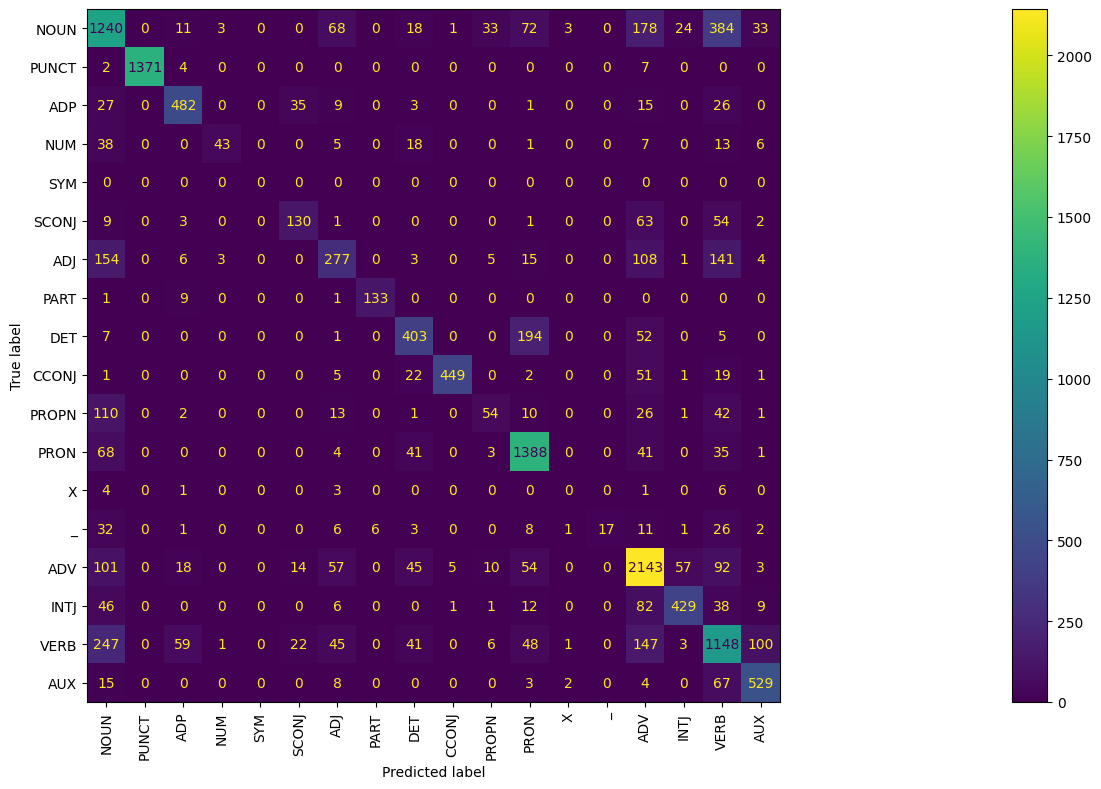

In [18]:
pred = save_metrics(
    pos_classes,
    test_pos_dl,
    clf_nn,
    task="upos",
    output=res_path,
    pad_token_id=tokenizer.pad_token_id
)

### Language Code Identification

In [19]:
dim = model.config.hidden_size
code_classes = get_code_mapping() # Mapping from class label to index
num_classes = len(code_classes)


clf_nn = RandomBaseline(
    num_classes=num_classes,
    vocab_size=tokenizer.vocab_size,
    dim=dim)

# Train model.
logs = train_model(
clf_nn,
train_code_dl,
val_code_dl,
lr=lr,
n_epochs=n_epochs,
pad_token_id=tokenizer.pad_token_id
)

Validating...: 100%|██████████| 51/51 [00:06<00:00,  7.59it/s]


Train Loss: 10.689102470874786	 Train Accuracy 0.7411545623836127
Val Loss: 21.85587254166603	 Val Accuracy 0.8462591240875912


Validating...: 100%|██████████| 51/51 [00:06<00:00,  7.58it/s]


Train Loss: 4.670281991362572	 Train Accuracy 0.9052348437823298
Val Loss: 19.54669626057148	 Val Accuracy 0.8665602189781022


Validating...: 100%|██████████| 51/51 [00:06<00:00,  7.58it/s]


Train Loss: 3.1328697875142097	 Train Accuracy 0.9391682184978274
Val Loss: 18.70973637700081	 Val Accuracy 0.8735553527980535


Validating...: 100%|██████████| 51/51 [00:06<00:00,  7.65it/s]


Train Loss: 2.608723036944866	 Train Accuracy 0.9509621353196772
Val Loss: 18.567787274718285	 Val Accuracy 0.8761405109489051


Validating...: 100%|██████████| 51/51 [00:06<00:00,  7.60it/s]

Train Loss: 2.377478376030922	 Train Accuracy 0.9509621353196772
Val Loss: 18.910523138940334	 Val Accuracy 0.8738594890510949


Predicting..: 100%|██████████| 51/51 [00:00<00:00, 373.87it/s]


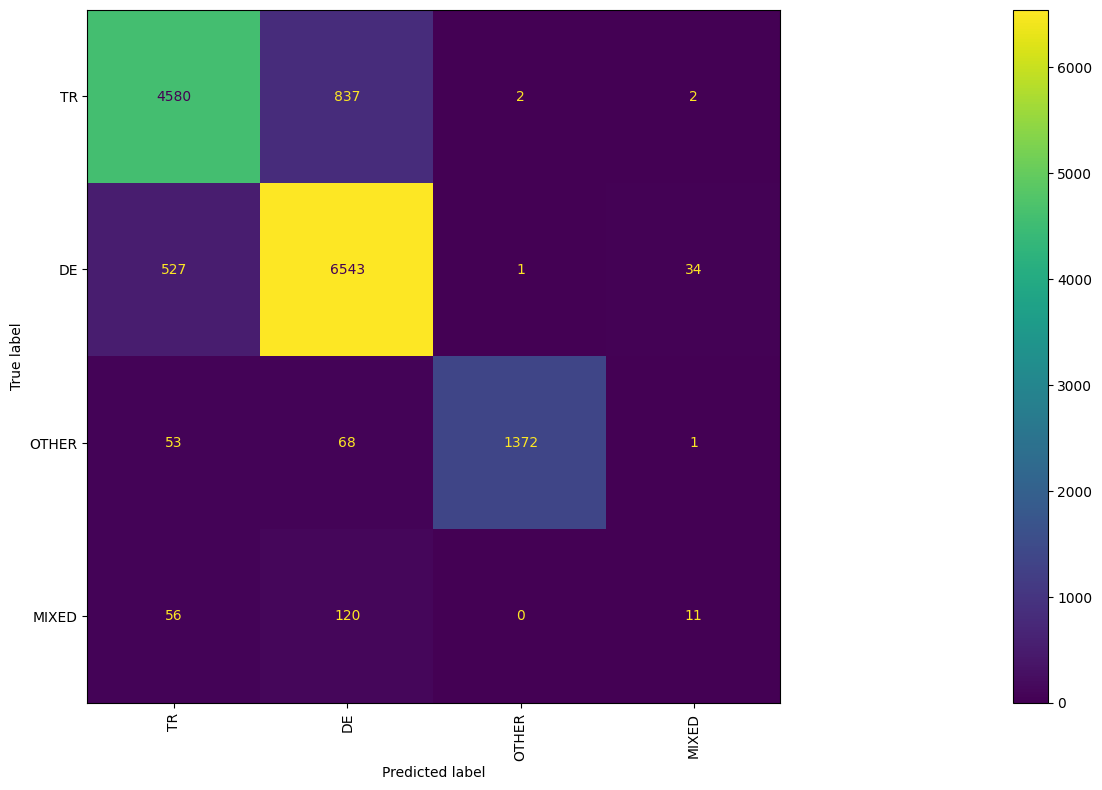

In [20]:
pred = save_metrics(
    code_classes,
    test_code_dl,
    clf_nn,
    task="lang-code",
    output=res_path,
    pad_token_id=tokenizer.pad_token_id
)